In [2]:
# write analog input onto DSC110 toptica scan
import sys
sys.path.append("..")
import nidaqmx
import numpy as np
import time
from LowLevelModules.Confocal import *
from LowLevelModules.GeneralFunctions import *
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from pymeasure.instruments.thorlabs import ThorlabsPM100USB
from scipy.optimize import curve_fit

from datetime import datetime

from LowLevelModules.NIdaq import *
import pandas as pd

In [2]:
from LowLevelModules.Spectroscopy import Spectrum
from LowLevelModules.GeneralFunctions import LivePlot2D, prettify_2d_plot
from LowLevelModules.LightField import LightField

import PrincetonInstruments.LightField.AddIns as AddIns
from PrincetonInstruments.LightField.Automation import Automation
from PrincetonInstruments.LightField.AddIns import CameraSettings
from PrincetonInstruments.LightField.AddIns import DeviceType
from PrincetonInstruments.LightField.AddIns import ExperimentSettings
from PrincetonInstruments.LightField.AddIns import SpectrometerSettings

In [65]:
import importlib
import LowLevelModules
importlib.reload(LowLevelModules.Confocal)
from LowLevelModules.Confocal import *

import LowLevelModules
importlib.reload(LowLevelModules.GeneralFunctions)
from LowLevelModules.GeneralFunctions import *

# Spectrometer

In [11]:
# # Initialize LightField --> make sure LF is closed before starting this initialization
# ts = time.time()
# LFauto = LightField()
# ttot = time.time()-ts
# print(f'LightField load time (s) = {ttot:.3f}')

Lightfield startup and setup OK
LightField load time (s) = 33.719


In [12]:
# # setup spectrometer
# wdir = r'Z:\Projects\Diamond NV centers\NV spectrometer\20200224'
# base_name = 'spectrometer test'
# acq_time = 1
# save_data = True

# #deal with LightField settings
# LFauto.set_acquisition_time(acq_time)
# LFauto.set_path(wdir)
# LFauto.set_filename(base_name)
# LFauto.set_filename_increment()

In [67]:

toptica_bounded_write(0)

# Power meter

In [3]:
# intialize power meter and wavemeter
PM100Addr = 'USB0::0x1313::0x8078::P0021814::INSTR'
PM = ThorlabsPM100USB(PM100Addr)

In [4]:
print(f'Thorlabs power (uW) = {PM.measure_power(737)*1e6:.0f}')

Thorlabs power (uW) = -0


# Shutter

In [2]:
shutter_ctrl_terminal ='/Dev1/port0/line1'
def shutter_ctrl_write(v):
    """write a digital signal to shutter
    maximum frequency of operation - 10 Hz (continuous)
    40 Hz - burst - 4 sec maximum with 1 minute minimum between burst
    """
    with nidaqmx.Task() as do_task:
        do_task.do_channels.add_do_chan(shutter_ctrl_terminal)
        do_task.write(v)       

In [3]:
shutter_ctrl_write(True)

## thorlabs power meter read 24 ms

In [13]:
nrepeat=5

ts = time.perf_counter()
for i in list(range(nrepeat)):
    try:
        p0=PM.measure_power(737)
    except:
        break

ttot = time.perf_counter()-ts
print(f'time (s) = {ttot/nrepeat:.9f}')

time (s) = 0.024082540


# Bristol read time 102 ms (wavelength + power)

In [3]:
bristol = Bristol()

In [ ]:
currentLambda,currentPower = bristol.readBristol()
print(f'Wavelength (nm-air) = {currentLambda: .4f}')
print(f'Bristol power (mW) = {currentPower: .3f}')

In [16]:
lambdalist = []
for i in np.arange(10):
    currentLambda,currentPower = bristol.readBristol()
    print(currentLambda)
    time.sleep(0.1)
    lambdalist.append(currentLambda)
print("average lambda (nm-air)")
print(np.average(lambdalist))

736.9458096225469
736.9433838567872
736.9457719841978
736.9446591298454
736.9442423573837
736.9464647770322
736.9448040432026
736.9442919576466
736.9465510430754
736.9469432041323
average lambda (nm-air)
736.945292197585


In [23]:
nrepeat=5

ts = time.perf_counter()
for i in list(range(nrepeat)):
    try:
        currentLambda,currentPower = bristol.readBristol()
    except:
        break

ttot = time.perf_counter()-ts
print(f'time (s) = {ttot/nrepeat:.9f}')

time (s) = 0.101925920


# FP_scan around 120 ms
# sometimes it got stuck (5-10% of the time) can take multiple seconds

In [34]:
nrepeat=2

ts = time.perf_counter()
for i in list(range(nrepeat)):
    try:
        t0_this,v_ao_scan_this,aiV_this = FP_scan()
    except:
        break

ttot = time.perf_counter()-ts
print(f'time (s) = {ttot/nrepeat:.9f}')

time (s) = 0.119487150


<font size="10">Monitor wavelength</font>

<IPython.core.display.Javascript object>


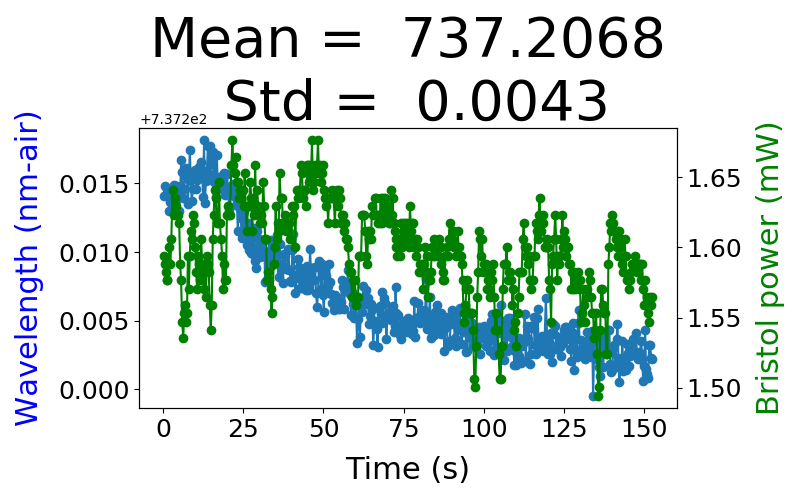

In [7]:
%matplotlib notebook
a,b,c=monitor_wavelength(bristol)

<font size="6">Scan laser piezo voltage</font>

In [8]:
help(scan_laser_piezo)

Help on function scan_laser_piezo in module LowLevelModules.Confocal:

scan_laser_piezo(bristol, PM, vstart=-5, vend=5, scanpts=50, PowerMeterOn=False, save_data=True, lasercurrent=nan, potreading=nan, PDOn=False, LFOn=False, LFauto=None, wdir=None)
    scan laser piezo voltage and monitor wavelength and power
    scan laser frequency in discrete steps
    software timed



In [36]:
help(FP_fit)

Help on function FP_fit in module LowLevelModules.Confocal:

FP_fit(tarray, piezo, PD, userange=250)
    fit a lorentzian + sine to the input
    assume piezo is either linearly increasing or decreasing
    only use the wave in [0:userange-1]    
    return (amp, cen, fwhm, bkg, asin,fsin,phisin)



In [11]:
help(FP_scan)

Help on function FP_scan in module LowLevelModules.Confocal:

FP_scan(ao_pts_half=250, v_final=6.0)
    Fabry Perot triangular scan - 0 V to v_final to 0 V
    scan and acquisition only
    return time series, FP piezo voltage, PD voltage (array)



<IPython.core.display.Javascript object>


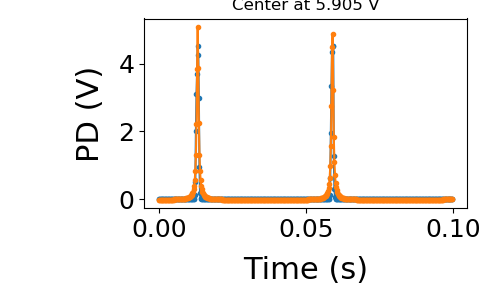

<IPython.core.display.Javascript object>


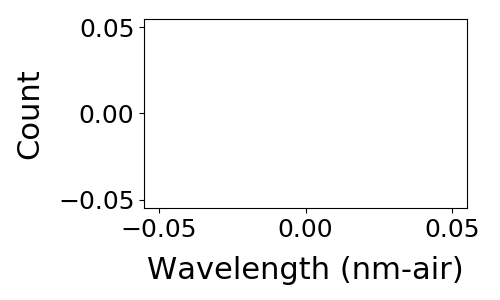

<IPython.core.display.Javascript object>


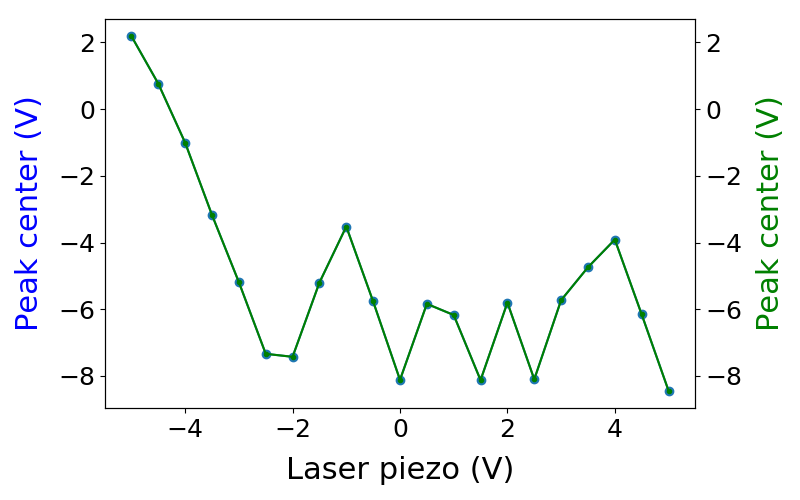

<IPython.core.display.Javascript object>


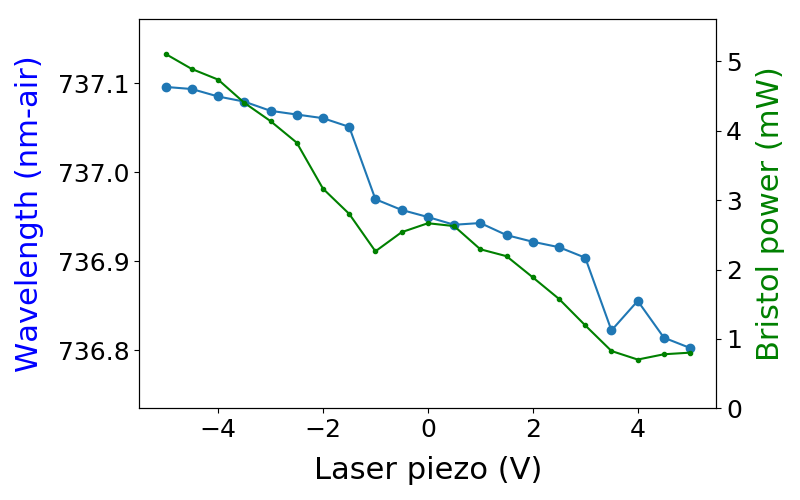

initial guess  [amp, cen, fwhm, bkg,x_FSR] [4.3658188188313005, 2.1442885771543083, 0.2, 0, 4.589178356713427]
FWHM 0.1172, FSR 4.5893, Finesse 39.1488
initial guess  [amp, cen, fwhm, bkg,x_FSR] [4.2975979159704645, 5.531062124248497, 0.2, 0, 4.609218436873748]
FWHM 0.1253, FSR 4.6886, Finesse 37.4153
initial guess  [amp, cen, fwhm, bkg,x_FSR] [4.373531426344907, 3.727454909819639, 0.2, 0, 4.509018036072145]
FWHM 0.1108, FSR 4.4681, Finesse 40.3329
initial guess  [amp, cen, fwhm, bkg,x_FSR] [4.3695417903611, 6.352705410821643, 0.2, 0, 4.529058116232465]
FWHM 0.1141, FSR 4.5998, Finesse 40.3012
initial guess  [amp, cen, fwhm, bkg,x_FSR] [4.378479892145182, 4.408817635270541, 0.2, 0, 4.3687374749499]
FWHM 0.0987, FSR 4.4444, Finesse 45.0391
initial guess  [amp, cen, fwhm, bkg,x_FSR] [4.376247142309933, 2.2645290581162323, 0.2, 0, 4.569138276553106]
FWHM 0.1089, FSR 4.5577, Finesse 41.8694
initial guess  [amp, cen, fwhm, bkg,x_FSR] [4.383179772437484, 6.973947895791583, 0.2, 0, 4.56913827

In [66]:
%matplotlib notebook
scan_laser_piezo(bristol,np.nan,-5,5,21,False,False,61,75)

# Check scans

In [4]:
# directory = r'C:\data\200311\TopticaScan'
# # filename = 'TopticaScan_190410.txt'

# usersDf1 = pd.read_csv(directory+'\\' + 'TopticaScan_202219' + '.txt', skiprows=5,delimiter =' ',header=None).values
# usersDf2 = pd.read_csv(directory+'\\' + 'TopticaScan_202401' + '.txt', skiprows=5,delimiter =' ',header=None).values
# usersDf3 = pd.read_csv(directory+'\\' + 'TopticaScan_202650' + '.txt', skiprows=5,delimiter =' ',header=None).values
# usersDf4 = pd.read_csv(directory+'\\' + 'TopticaScan_202817' + '.txt', skiprows=5,delimiter =' ',header=None).values

(736.5, 737.15)

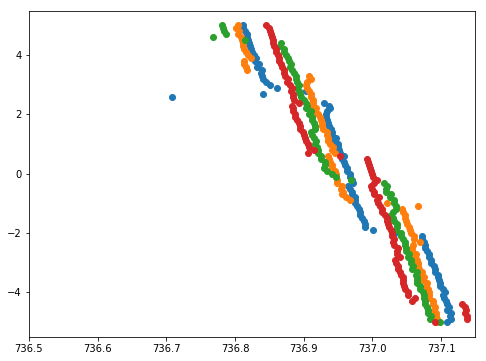

In [5]:
# fig=plt.figure(figsize=(8,6))

# # plt.plot(usersDf1[:,0],usersDf1[:,1],marker='o',linestyle="None")
# # plt.plot(usersDf2[:,0],usersDf2[:,1],marker='o',linestyle="None")
# # plt.plot(usersDf3[:,0],usersDf3[:,1],marker='o',linestyle="None")
# # plt.plot(usersDf4[:,0],usersDf4[:,1],marker='o',linestyle="None")

# plt.plot(usersDf1[:,1],usersDf1[:,0],marker='o',linestyle="None")
# plt.plot(usersDf2[:,1],usersDf2[:,0],marker='o',linestyle="None")
# plt.plot(usersDf3[:,1],usersDf3[:,0],marker='o',linestyle="None")
# plt.plot(usersDf4[:,1],usersDf4[:,0],marker='o',linestyle="None")
# # plt.plot(usersDf5[:,1],usersDf5[:,0],marker='o',linestyle="None")
# # plt.plot(usersDf6[:,1],usersDf6[:,0],marker='o',linestyle="None")
# # plt.plot(usersDf7[:,1],usersDf7[:,0],marker='o',linestyle="None")
# # plt.plot(usersDf8[:,1],usersDf8[:,0],marker='o',linestyle="None")
# plt.xlim(736.5,737.15)

# Fit wavelength to a piecewise linear function

In [11]:
# near 737 nm

299792458/(1.00027549*737)*1/737

551.7801842928258

In [43]:
import importlib
import LowLevelModules
importlib.reload(LowLevelModules.Confocal)
from LowLevelModules.Confocal import *

<IPython.core.display.Javascript object>


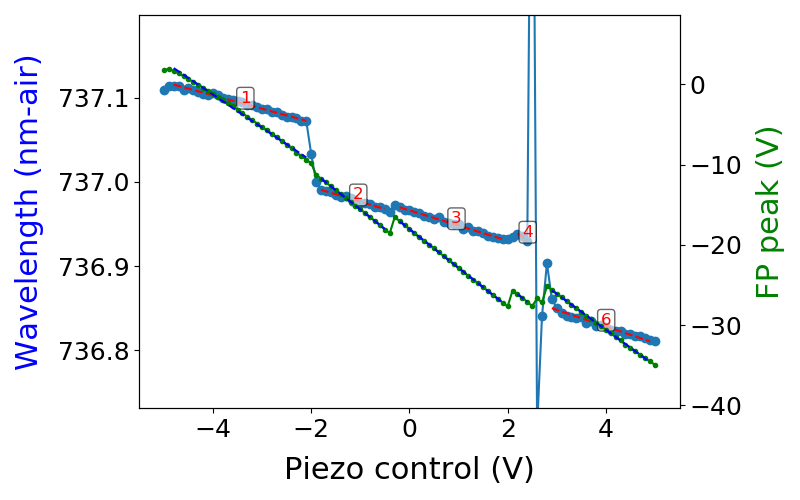

Wavelength in air
Index, Wavelength range (nm),Slope (nm/Vpiezo), FP slope (V/Vpiezo), FP slope (GHz/Vpiezo), Computed slope from cavity (nm/Vpiezo)
1,0.0460,-0.0159,-4.123,-8.62,-0.0156
2,0.0263,-0.0176,-4.832,-10.10,-0.0183
3,0.0414,-0.0180,-4.829,-10.10,-0.0183
4,0.0156,-0.0390,-4.683,-9.79,-0.0177
6,0.0433,-0.0197,-4.467,-9.34,-0.0169


<IPython.core.display.Javascript object>


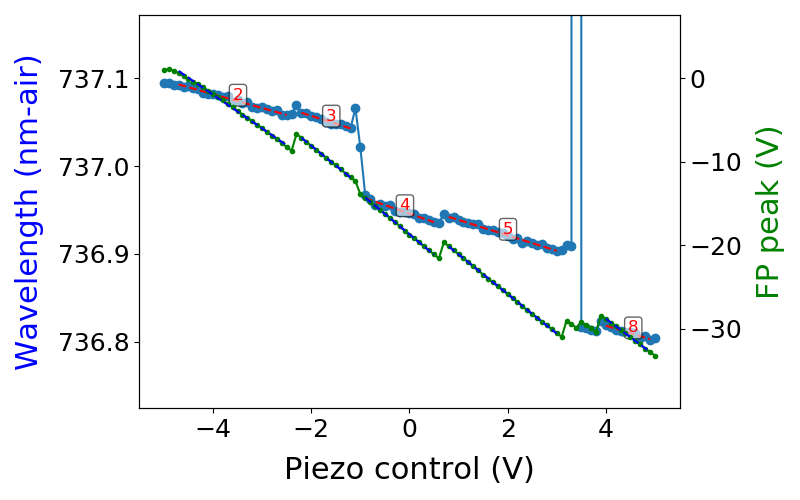

Wavelength in air
Index, Wavelength range (nm),Slope (nm/Vpiezo), FP slope (V/Vpiezo), FP slope (GHz/Vpiezo), Computed slope from cavity (nm/Vpiezo)
2,0.0379,-0.0158,-4.043,-8.45,-0.0153
3,0.0213,-0.0178,-4.741,-9.91,-0.0180
4,0.0311,-0.0194,-4.875,-10.19,-0.0185
5,0.0422,-0.0176,-4.746,-9.92,-0.0180
8,0.0188,-0.0171,-4.413,-9.23,-0.0167


<IPython.core.display.Javascript object>


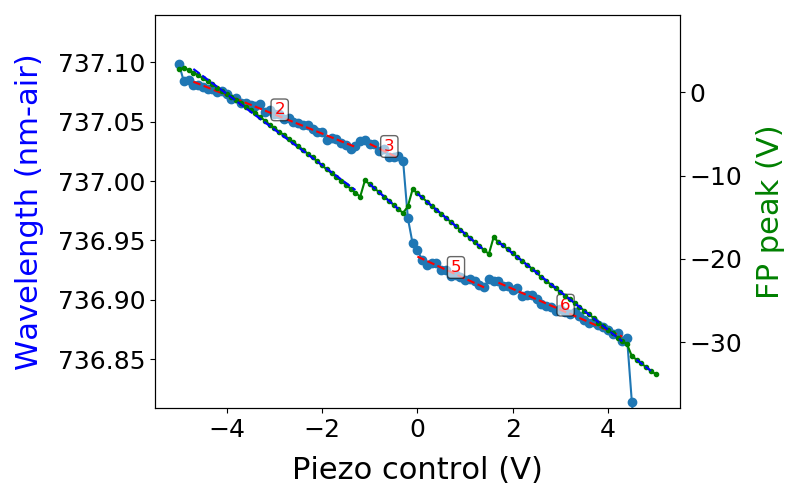

Wavelength in air
Index, Wavelength range (nm),Slope (nm/Vpiezo), FP slope (V/Vpiezo), FP slope (GHz/Vpiezo), Computed slope from cavity (nm/Vpiezo)
2,0.0582,-0.0162,-4.278,-8.94,-0.0162
3,0.0159,-0.0199,-4.959,-10.37,-0.0188
5,0.0297,-0.0185,-4.839,-10.12,-0.0183
6,0.0490,-0.0175,-4.592,-9.60,-0.0174
7,-0.0207,0.0415,-4.471,-9.35,-0.0169


<IPython.core.display.Javascript object>


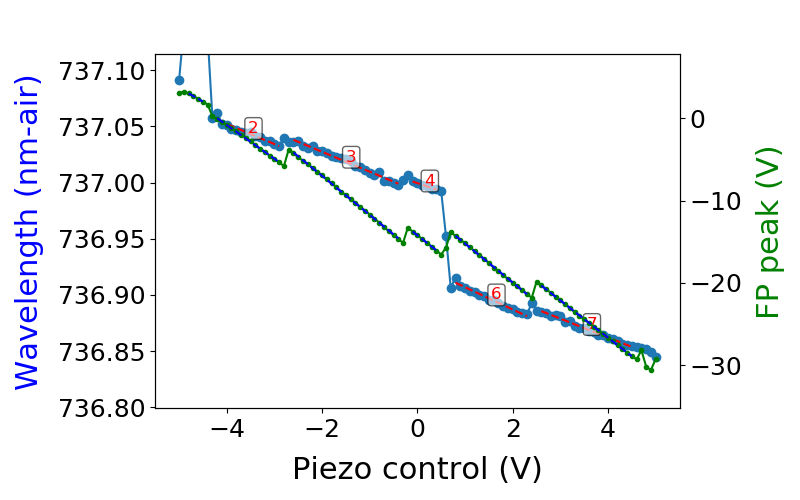

Wavelength in air
Index, Wavelength range (nm),Slope (nm/Vpiezo), FP slope (V/Vpiezo), FP slope (GHz/Vpiezo), Computed slope from cavity (nm/Vpiezo)
1,0.0040,-0.0080,-3.299,-6.90,-0.0125
2,0.0268,-0.0179,-4.099,-8.57,-0.0155
3,0.0425,-0.0177,-4.739,-9.91,-0.0180
4,0.0099,-0.0142,-4.596,-9.61,-0.0174
6,0.0337,-0.0198,-4.736,-9.90,-0.0179
7,0.0352,-0.0167,-4.518,-9.45,-0.0171


In [44]:
%matplotlib notebook
# directory = r'C:\data\200311\TopticaScan'
directory = r'Z:\Projects\Diamond NV centers\B13 data\200311\TopticaScan'
# fileprefix = 'TopticaScan_071904'

lpLR1,mode_hop_free1=fit_wavelength_segments(directory,'TopticaScan_202219') # pot reading 80
lpLR2,mode_hop_free2=fit_wavelength_segments(directory,'TopticaScan_202401')
lpLR3,mode_hop_free3=fit_wavelength_segments(directory,'TopticaScan_202650')
lpLR4,mode_hop_free4=fit_wavelength_segments(directory,'TopticaScan_202817')

In [ ]:
# output mode hop free tuning range
# 1) separate
# 2) on the same line

In [34]:
def plot_intervals(ax,mode_hop_free,marker,ind,step=None,label=None):
    if step is None:
        step = 1/mode_hop_free.shape[0]
    for i,v in enumerate(mode_hop_free):
        if i==0:
            ax.plot(mode_hop_free[i,0:2],[ind+i*step,ind+i*step],marker,markersize=4,label=label)
        else:
            ax.plot(mode_hop_free[i,0:2],[ind+i*step,ind+i*step],marker,markersize=4)
        ax.annotate(f'{mode_hop_free[i,4]:.3f}, {mode_hop_free[i,3]:.3f}',(mode_hop_free[i,0],ind+i*step+0.3),fontsize=8,color=marker[0],
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.6))
#         ax.annotate(f'{mode_hop_free[i,4]:.3f}',(mode_hop_free[i,1],ind+i*step+0.3),fontsize=8,color='black',
#                      bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.6))

<IPython.core.display.Javascript object>


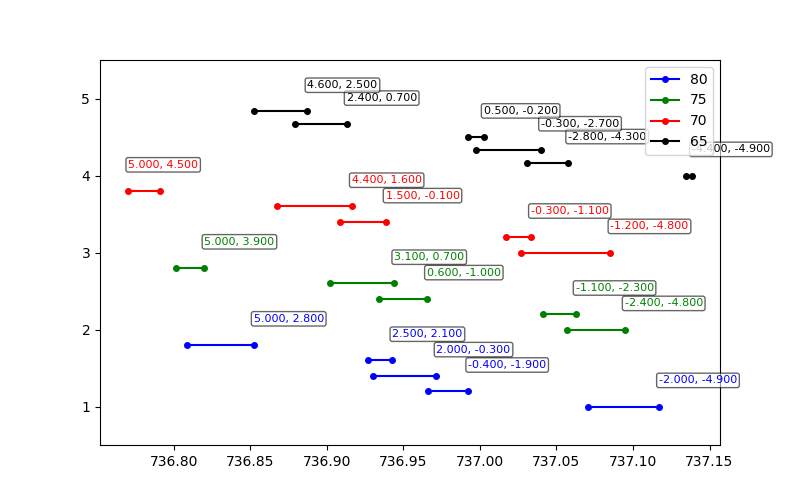

In [35]:
fig = plt.figure(figsize=(8, 5))

ax1 = fig.add_subplot(111)

plot_intervals(ax1,mode_hop_free1,'bo-',1,label=80)
plot_intervals(ax1,mode_hop_free2,'go-',2,label=75)
plot_intervals(ax1,mode_hop_free3,'ro-',3,label=70)
plot_intervals(ax1,mode_hop_free4,'ko-',4,label=65)
ax1.set_ylim(0.5,5.5)
ax1.legend()

<IPython.core.display.Javascript object>


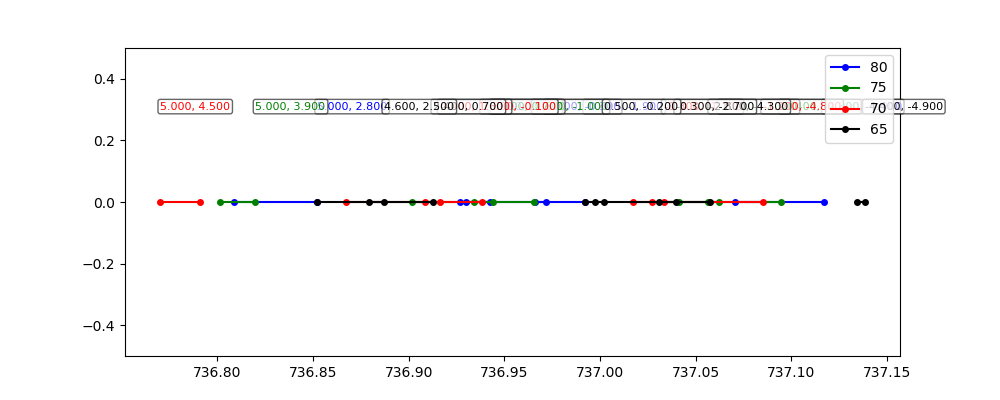

In [42]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(111)

plot_intervals(ax1,mode_hop_free1,'bo-',0,step=0,label=80)
plot_intervals(ax1,mode_hop_free2,'go-',0,step=0,label=75)
plot_intervals(ax1,mode_hop_free3,'ro-',0,step=0,label=70)
plot_intervals(ax1,mode_hop_free4,'ko-',0,step=0,label=65)
ax1.set_ylim(-0.5,0.5)
ax1.legend()